In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
import scipy as sci
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import cdo
from scipy.spatial import KDTree

In [15]:
def get_variable_1d(len_data, data, variable, height_level, hour): #data is the output of 'get_data', variable is e.g. 'T' (as str), height_level (mostly 1 for urban), hour is time in this case 0 because one file only has one timestep
    ds_data = {}
    for i in range(1, len_data + 1):
        ds_data[i] = data[i][f'{variable}'].isel(time = hour, height_2 = height_level)
    
    return ds_data

In [82]:
ds_opr_21 = xr.open_dataset('../synoptical_cond_files/fc_DOM01_0002_OPR_urban_grid_2021.nc')
ds_opr_22 = xr.open_dataset('../synoptical_cond_files/fc_DOM01_0002_OPR_urban_grid_2022.nc')

In [85]:
ds_opr_21.variables

Frozen({'clon_bnds': <xarray.Variable (cell: 247, nv: 3)>
[741 values with dtype=float64], 'clat_bnds': <xarray.Variable (cell: 247, nv: 3)>
[741 values with dtype=float64], 'height_bnds': <xarray.Variable (height: 90, bnds: 2, cell: 247)>
[44460 values with dtype=float64], 'depth_2_bnds': <xarray.Variable (depth_2: 8, bnds: 2, cell: 247)>
[3952 values with dtype=float64], 'plev_bnds': <xarray.Variable (plev: 1, bnds: 2, cell: 247)>
[494 values with dtype=float64], 'plev_2_bnds': <xarray.Variable (plev_2: 1, bnds: 2, cell: 247)>
[494 values with dtype=float64], 'plev_3_bnds': <xarray.Variable (plev_3: 1, bnds: 2, cell: 247)>
[494 values with dtype=float64], 'QV': <xarray.Variable (time: 1, height: 90, cell: 247)>
[22230 values with dtype=float32]
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific Humidity
    units:          kg kg-1
    param:          0.1.0
    CDI_grid_type:  unstructured, 'QC': <xarray.Variable (time: 1, height: 90, cell: 247)>
[22230 val

/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


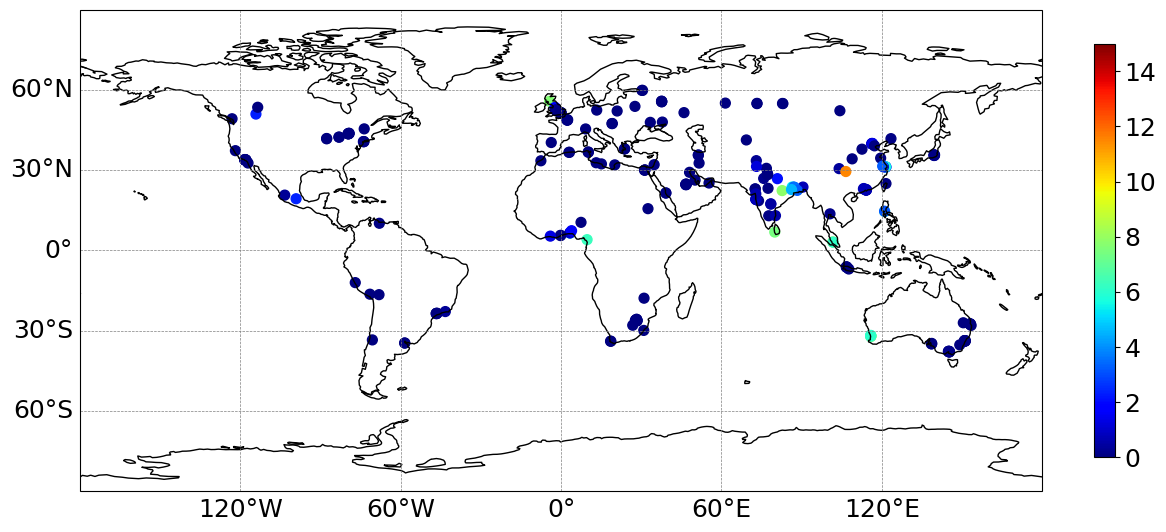

In [90]:
params = {'axes.labelsize': 18,'axes.titlesize':18, 'legend.fontsize': 18, 'xtick.labelsize': 18, 
          'ytick.labelsize': 18}
plt.rcParams.update(params)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(np.rad2deg(ds_opr_21['clon']), np.rad2deg(ds_opr_21['clat']), c=ds_opr_21['RAIN_CON'] , cmap='jet',
                transform=ccrs.PlateCarree(), s=50, alpha=1, vmin=0, vmax = 15)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical',
                    fraction=0.02)

ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xlabel_style, gl.ylabel_style = {'fontsize': 18}, {'fontsize': 18}


plt.tight_layout()
plt.savefig('../plots_2024/con_precip_21_cities.jpeg')


/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


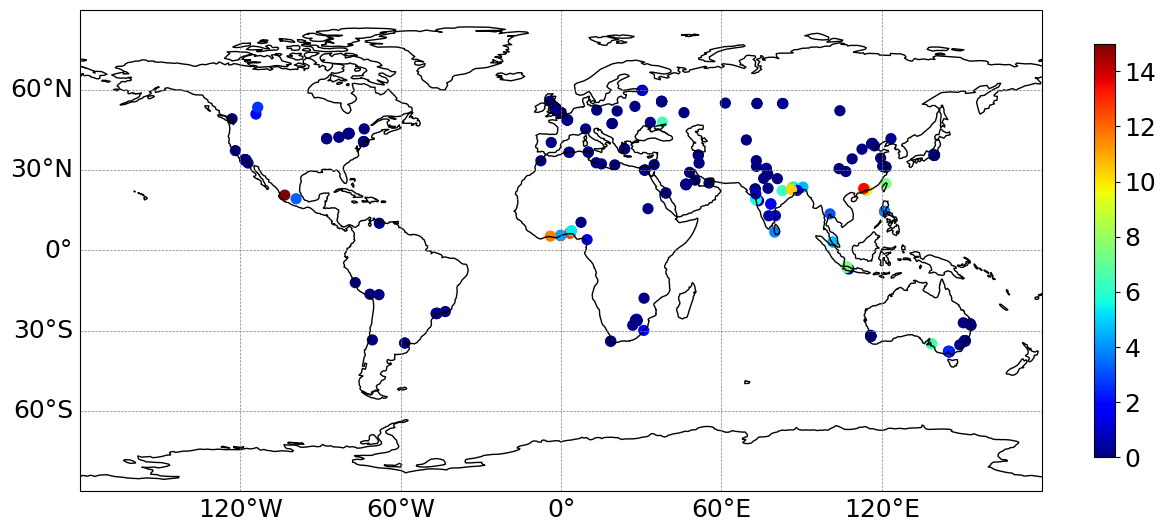

In [172]:
params = {'axes.labelsize': 18,'axes.titlesize':18, 'legend.fontsize': 18, 'xtick.labelsize': 18, 
          'ytick.labelsize': 18}
plt.rcParams.update(params)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(np.rad2deg(ds_opr_22['clon']), np.rad2deg(ds_opr_22['clat']), c=ds_opr_22['RAIN_CON'] , cmap='jet',
                transform=ccrs.PlateCarree(), s=50, alpha=1, vmin=0, vmax = 15)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical',
                    fraction=0.02)

ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xlabel_style, gl.ylabel_style = {'fontsize': 18}, {'fontsize': 18}


plt.tight_layout()
plt.savefig('../plots_2024/con_precip_22_cities.jpeg')


In [178]:
import matplotlib.tri as tri
import cartopy.feature as cfeature

In [214]:
# Convert vertex coordinates from radians to degrees
x      = np.rad2deg(ds_opr_22.clon)
y      = np.rad2deg(ds_opr_22.clat)

# Create  Delaunay triangulation. 
triang = tri.Triangulation(x, y)
var = ds_opr_22.RAIN_GSP[0,:]

In [215]:
ds_opr_22.RAIN_GSP

<xarray.DataArray 'RAIN_GSP' (time: 1, cell: 247)>
array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-15T12:00:00
    clon     (cell) float64 0.6574 0.656 0.6559 0.6572 ... -1.232 0.325 0.323
    clat     (cell) float64 0.9736 0.9751 0.9721 ... -0.5839 -0.5921 -0.5926
Dimensions without coordinates: cell
Attributes:
    long_name:      Large scale rain (Accumulation)
    units:          kg m-2
    param:          77.1.0
    CDI_grid_type:  unstructured

/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


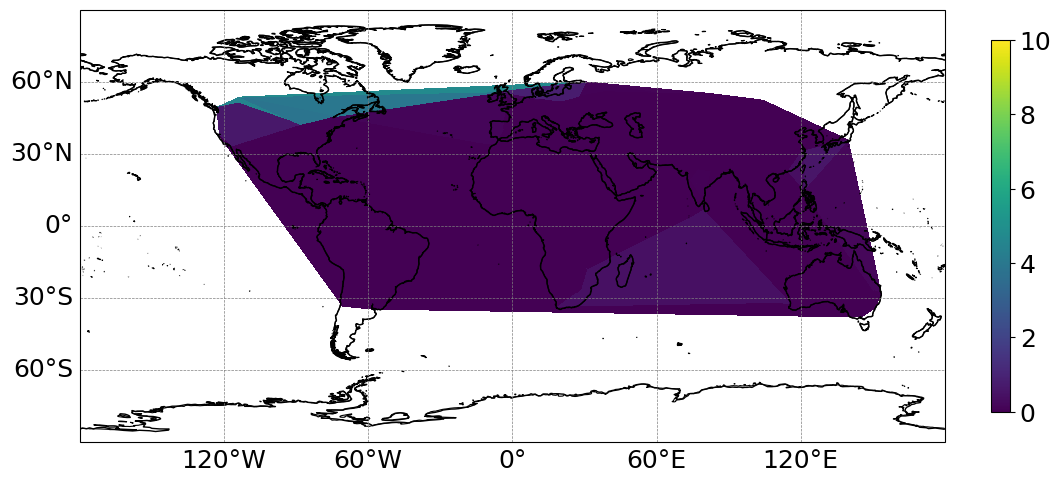

In [216]:
plt.figure(figsize=(12,12))

pc = ccrs.PlateCarree()

ax = plt.axes(projection=pc)                         
ax.coastlines('50m', linewidth=0.8)                    

ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xlabel_style, gl.ylabel_style = {'fontsize': 18}, {'fontsize': 18}

plt.figure
plt.tripcolor(triang, var)
cbar = plt.colorbar(label='', fraction=0.02)
plt.clim(0, 10)  # Set the range of the plot

#plt.savefig('con_precip_21_cities.jpeg')